In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset
df = pd.read_csv("tweets_with_roberta_sentiment.csv")

# Drop rows with missing clean_text or sentiment
df = df.dropna(subset=["clean_text", "roberta_sentiment"])

# Encode sentiment labels
label_encoder = LabelEncoder()
df["sentiment_label"] = label_encoder.fit_transform(df["roberta_sentiment"])

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])

# Pad sequences to a max length
max_length = 30
X = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Labels
y = df["sentiment_label"].values

# Check label encoding
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),  # Removed input_length
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [3]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)


Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4177 - loss: 1.0784 - val_accuracy: 0.5682 - val_loss: 0.9233
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5797 - loss: 0.8639 - val_accuracy: 0.6023 - val_loss: 0.8045
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6460 - loss: 0.6825 - val_accuracy: 0.6087 - val_loss: 0.8181
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6707 - loss: 0.6138 - val_accuracy: 0.5885 - val_loss: 0.9304
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7069 - loss: 0.5591 - val_accuracy: 0.6386 - val_loss: 1.0863


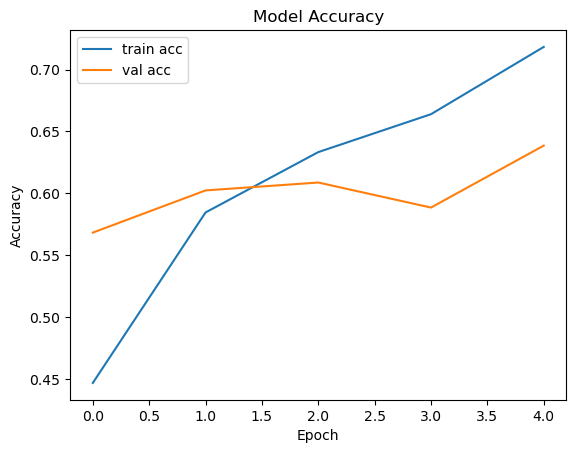

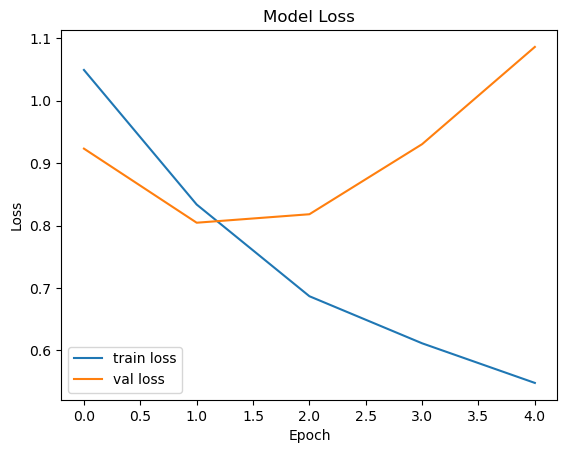

In [4]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
📋 Classification Report:

              precision    recall  f1-score   support

    negative       0.71      0.75      0.73       277
     neutral       0.68      0.60      0.64       405
    positive       0.52      0.57      0.54       256

    accuracy                           0.64       938
   macro avg       0.63      0.64      0.64       938
weighted avg       0.64      0.64      0.64       938



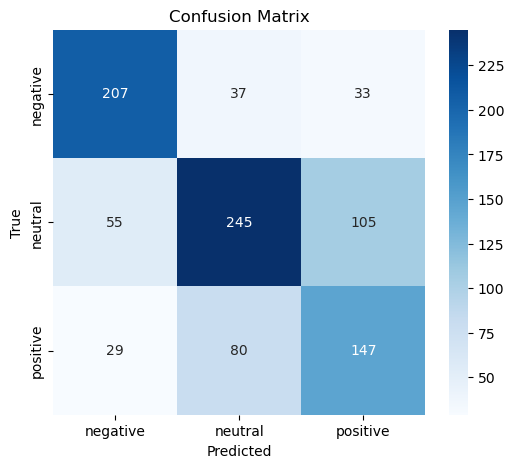

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Then train like this:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32,
          class_weight=class_weights_dict)


{0: 1.220703125, 1: 0.7783312577833126, 2: 1.1160714285714286}
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8404 - loss: 0.3981 - val_accuracy: 0.6727 - val_loss: 1.0424
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8996 - loss: 0.2776 - val_accuracy: 0.6940 - val_loss: 1.1018
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9211 - loss: 0.2207 - val_accuracy: 0.6951 - val_loss: 1.0182
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9391 - loss: 0.1925 - val_accuracy: 0.7068 - val_loss: 1.1664
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9509 - loss: 0.1461 - val_accuracy: 0.7068 - val_loss: 1.2028
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9614 - loss: 0.1382 - val_accuracy: 0.6983 - val_loss: 1.3521
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9461 - loss: 0.1579 - val_accuracy: 0.7111 - val_loss: 1.2474
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
📋 Updated Classification Report:

              precision    recall  f1-score   support

    negative       0.71      0.74      0.72       277
     neutral       0.72      0.68      0.70       405
    positive       0.67      0.69      0.68       256

    accuracy                           0.70       938
   macro avg       0.70      0.70      0.70       938
weighted avg       0.70      0.70      0.70       938



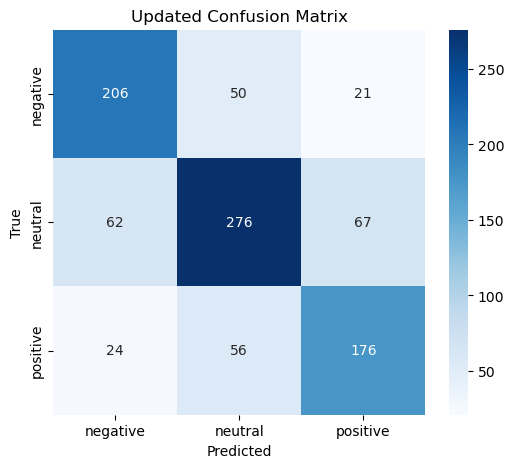

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict again
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📋 Updated Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Updated Confusion Matrix")
plt.show()


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Then train like this:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=75, 
          batch_size=32,
          class_weight=class_weights_dict)

{0: 1.220703125, 1: 0.7783312577833126, 2: 1.1160714285714286}
Epoch 1/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9621 - loss: 0.1174 - val_accuracy: 0.6226 - val_loss: 1.7892
Epoch 2/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9507 - loss: 0.1452 - val_accuracy: 0.7015 - val_loss: 1.3786
Epoch 3/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9699 - loss: 0.1029 - val_accuracy: 0.7004 - val_loss: 1.3816
Epoch 4/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9676 - loss: 0.0948 - val_accuracy: 0.6972 - val_loss: 1.4717
Epoch 5/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9707 - loss: 0.0795 - val_accuracy: 0.6972 - val_loss: 1.7402
Epoch 6/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9713 - loss: 0.0817 - val_accuracy: 0.7004 - val_loss: 1.6150
Epoch 7/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9679 - loss: 0.0861 - val_accuracy: 0.7058 - val_loss: 1.7288
Epoch 8/75
118/118 ━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
📋 Updated Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.74      0.71       277
     neutral       0.71      0.69      0.70       405
    positive       0.68      0.65      0.67       256

    accuracy                           0.70       938
   macro avg       0.69      0.69      0.69       938
weighted avg       0.70      0.70      0.69       938



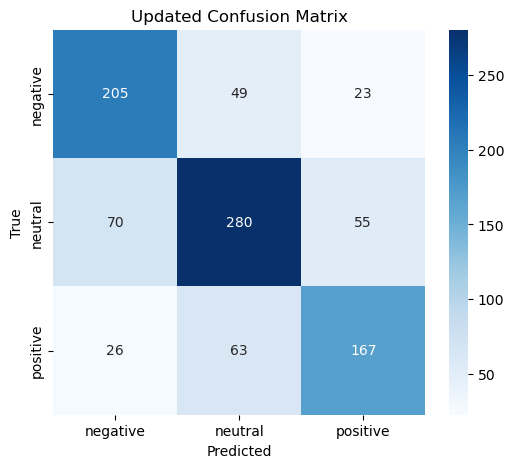

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict again
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📋 Updated Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Updated Confusion Matrix")
plt.show()